In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim
import numpy as np 

In [9]:
device = torch.device('mps')

transform = transforms.Compose([
        transforms.ToTensor()
    ])

train_dataset = torchvision.datasets.MNIST(
    '~/ML/data/', 
    train=True, 
    download=True,
    transform=transform,
)
train_dataset.data.to(device)
train_dataset.targets.to(device)


test_dataset = torchvision.datasets.MNIST(
    '~/ML/data/',
    train=False,
    download=True,
    transform=transform
)
test_dataset.data.to(device)
test_dataset.targets.to(device)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=128, shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=1024, shuffle=True 
)

In [3]:
class AutoEnc(nn.Module):
    def __init__(self, encoded_space_dim):
        super().__init__()
        self.latent_dim = encoded_space_dim
        
        self.encoder = nn.Sequential(
            # Convolution
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.ReLU(True),
            # Flatten
            nn.Flatten(start_dim=1),
            # Linear Layer
            nn.Linear(3*3*32, 128),
            nn.ReLU(True),
            nn.Linear(128, encoded_space_dim)
        )
        
        self.decoder = nn.Sequential(
            # Linear Layer
            nn.Linear(encoded_space_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 3 * 3 * 32),
            nn.ReLU(True),
            # Unflatten
            nn.Unflatten(dim=1, unflattened_size=(32, 3, 3)),
            # Conv Transpose
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(encoded_space_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 10),
        )
        
    def decode(self, x):
        x = self.decoder(x)
        x = torch.sigmoid(x)
        return x
    
    def encode(self, x):
        return self.encoder(x)
    
    def predict(self, x):
        logits = self.classifier(self.encoder(x))
        return logits.max(0, True).indices.item()
    
network = AutoEnc(10).to(device)
optimizer = optim.Adam(network.parameters())

In [4]:
train_log_batch = 100
def train(epoch):
    network.train()
    total_loss_reconstruct = 0
    total_loss_classify = 0
    total_correct = 0
    count = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device)
        target = target.to(device)
        
        optimizer.zero_grad()
        # Encoder-Decoder Loss
        latent_rep = network.encode(data)
        decoded = network.decode(latent_rep)
        ## MSE
        enc_loss = F.mse_loss(data, decoded)
        
        # Classification Loss
        logits = network.classifier(latent_rep.detach())
        class_loss = F.cross_entropy(logits, target)
        total_correct += (logits.max(1, keepdim=True).indices.squeeze(1) == target).sum()
        
        loss = enc_loss + class_loss
        loss.backward()
        optimizer.step()
        total_loss_reconstruct += enc_loss.item()
        total_loss_classify += class_loss.item()

        count+=target.shape[0]

        if (batch_idx+1) % train_log_batch == 0:
            print("\tTrain Batch: {} Reconstruction Loss: {:.6f} Classification Loss: {:.6f} Accuracy: {:.6f}".format(batch_idx+1, total_loss_reconstruct/count, total_loss_classify/count, total_correct/count))
            
    print('Train Epoch: {} Loss: {:.6f}\n'.format(epoch, total_loss_reconstruct/count, total_loss_classify/count))


In [5]:
def test():
    network.eval() 
    total_loss_reconstruct = 0
    total_loss_classify = 0
    total_correct = 0
    count = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        data = data.to(device)
        target = target.to(device)
        
        latent_rep = network.encode(data)
        decoded = network.decode(latent_rep)
        logits = network.classifier(latent_rep)

        class_loss = F.nll_loss(logits, target)
        recon_loss = F.mse_loss(data, decoded)
        
        total_correct += (logits.max(1, keepdim=True).indices.squeeze(1) == target).sum()
        total_loss_classify += class_loss.item()
        total_loss_reconstruct += recon_loss.item()
        
        count+=target.shape[0]
        
    print('Test Reconstruction Loss: {:.6f} Classification Loss: {:.6f} Accuracy: {:.6f}\n'.format(total_loss_reconstruct/count, total_loss_classify/count, total_correct/count))

In [10]:
network = AutoEnc(10).to(device)
optimizer = optim.Adam(network.parameters())

epochs = 5
for epoch in range(epochs):
    train(epoch)
    test()
    

	Train Batch: 100 Reconstruction Loss: 0.001444 Classification Loss: 0.017386 Accuracy: 0.227812
	Train Batch: 200 Reconstruction Loss: 0.001064 Classification Loss: 0.013787 Accuracy: 0.412227
	Train Batch: 300 Reconstruction Loss: 0.000852 Classification Loss: 0.011192 Accuracy: 0.523698
	Train Batch: 400 Reconstruction Loss: 0.000727 Classification Loss: 0.009453 Accuracy: 0.601836
Train Epoch: 0 Loss: 0.000667

Test Reconstruction Loss: 0.000039 Classification Loss: -0.005727 Accuracy: 0.875650

	Train Batch: 100 Reconstruction Loss: 0.000302 Classification Loss: 0.003036 Accuracy: 0.882734
	Train Batch: 200 Reconstruction Loss: 0.000294 Classification Loss: 0.002916 Accuracy: 0.887539
	Train Batch: 300 Reconstruction Loss: 0.000287 Classification Loss: 0.002807 Accuracy: 0.891120
	Train Batch: 400 Reconstruction Loss: 0.000281 Classification Loss: 0.002690 Accuracy: 0.895684
Train Epoch: 1 Loss: 0.000278

Test Reconstruction Loss: 0.000032 Classification Loss: -0.006771 Accuracy: 

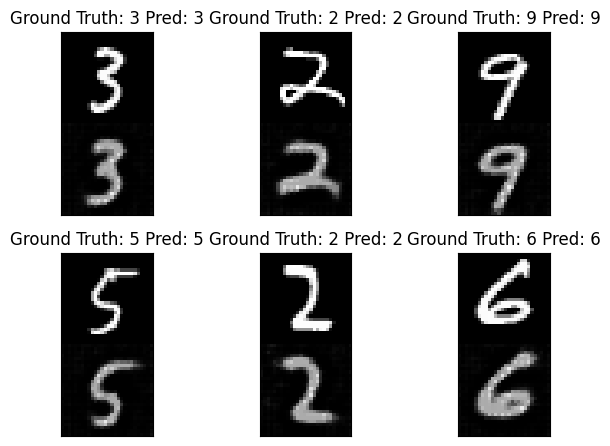

In [11]:
# Visualize the reconstruction
import matplotlib.pyplot as plt

def plot_images(n, data, targets=False, predictions=False):
    fig = plt.figure()
    ncols = 3
    nrows = n//ncols
    for i in range(n):
      plt.subplot(nrows, ncols,i+1)
      plt.tight_layout()
      plt.imshow(data[i].detach().cpu(), cmap='gray', interpolation='none')
      if torch.is_tensor(targets):
          plt.title("Ground Truth: {} Pred: {}".format(targets[i], predictions[i]))
      plt.xticks([])
      plt.yticks([])

      fig

examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

count = 6
images = [] 
predictions = []
for idx in range(count):
    img = example_data[idx].to(device)
    latent_rep = network.encode(img.unsqueeze(0))
    reconstructed_img = network.decode(latent_rep).squeeze(0)
    pred = network.classifier(latent_rep).squeeze(0).max(0, keepdim=True).indices.item()
    
    joint = torch.cat([img.to(device), reconstructed_img], dim=1)[0]
    predictions.append(pred)
    images.append(joint)
plot_images(count, images, example_targets, predictions)

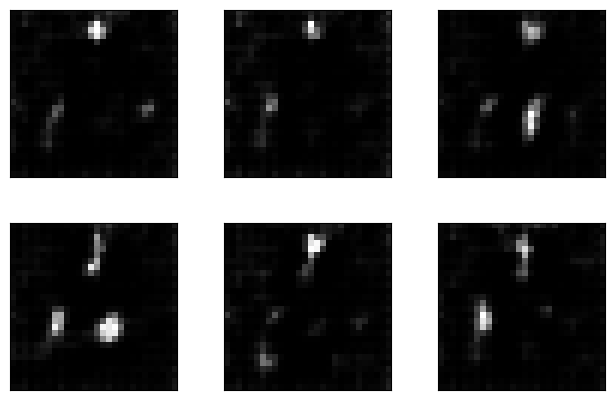

In [12]:
# Create new samples (Randomly Sampled)
count = 6
latent_reps = torch.rand([count, network.latent_dim]).to(device)
images = network.decode(latent_reps).squeeze(1)
plot_images(count, images)
    

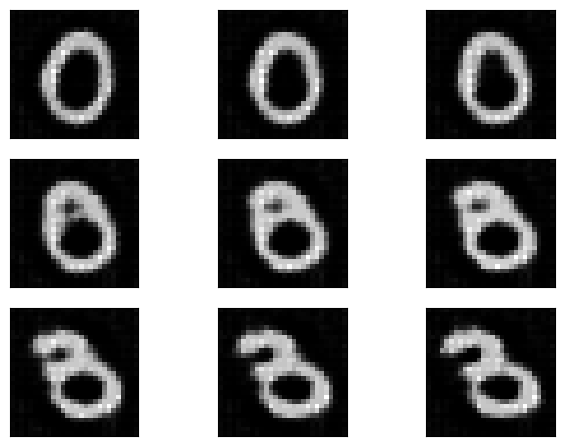

In [19]:
# Morph 

digits = [0, 3]
d1 = False
d2 = False
for idx, num in enumerate(test_dataset.targets):
    if (num == digits[0]):
        d1 = test_dataset.data[idx].type(torch.float32) / 255
    if (num == digits[1]):
        d2 = test_dataset.data[idx].type(torch.float32) / 255
    if (torch.is_tensor(d1) and torch.is_tensor(d2)):
        break

def enc(d):
    return network.encode(d.reshape([1, 1, 28, 28]).to(device))

def lerp(a, b, t):
    return a + (b - a) * t

l1 = enc(d1)
l2 = enc(d2)

steps = 8
images = []
for step in range(steps+1):
    latent_rep = lerp(l1, l2, step/steps)
    img = network.decode(latent_rep).reshape([28, 28])
    images.append(img)
    
plot_images(steps+1, images)

In [14]:
# Explore the statistics of the latent dimension

test_latent = torch.tensor([]).to(device)
for (data, target) in iter(test_loader): 
    data = data.to(device)
    latent_rep = network.encode(data)
    
    test_latent = torch.cat([test_latent, latent_rep], dim=0)
    

In [16]:
# mean of each dim 
mean = test_latent.mean(dim=0)
std = test_latent.std(dim = 0)

In [17]:
mean, std

(tensor([-0.5749, -0.2154,  0.3213, -0.7461, -0.3609,  0.8425, -0.3911, -0.0210,
          0.0166, -0.6089], device='mps:0', grad_fn=<MeanBackward1>),
 tensor([0.7420, 0.6089, 0.5779, 0.6867, 0.7205, 0.5997, 0.7246, 0.6679, 0.6647,
         0.6207], device='mps:0', grad_fn=<StdBackward0>))